In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor

from shapely import wkt
import matplotlib.patches as mpatches
import colorsys
from matplotlib.colors import to_hex
import contextily as ctx

from utils import make_precinct_counts,make_demo_map,job_cols,race_cols,cols_to_keep,scale_and_cluster,make_edname,map_round_votes,make_pc_map

In [2]:
import matplotlib.patches as mpatches
import colorsys
from matplotlib.colors import to_hex
import contextily as ctx

In [39]:
#import pca from sklearn 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [13]:
demo_cluster = pd.read_csv('../../chapter_two/data/occupation_demo_clusters_on_ed.csv')
#d18 = pd.read_csv('../../cc_election_cleaning/all_rounds_results/district_18.csv')
ed_level = pd.read_csv('../../cc_election_cleaning/occupation_demo_data_feb21.csv')

ed_shapefile = '../../chapter_two/data/nyed_21a/nyed.shp'
ed_gdf = gpd.read_file(ed_shapefile)

full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')

full_results_eighteen = full_results[full_results['district'] == 18]
af_full = full_results[full_results['candidate'] == 'Amanda Farias']
winner_twenty_two = full_results_eighteen[full_results_eighteen['winner'] == True]
occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')
eds_18 = full_results_eighteen['ed_name'].unique().tolist()
ae = pd.read_csv('../../cc_election_cleaning/ae_precincts.csv')
eds_18 = full_results_eighteen['ed_name'].unique().tolist()

In [14]:
p_cols = [col for col in occ_df.columns if col[-1] == 'p']
wp_cols = [col for col in occ_df.columns if col.startswith("w2") and col.endswith("p")]
wp_cols.remove('w2cop')
to_remove = [ 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip']
wp_cols = [col for col in wp_cols if col not in to_remove]

In [5]:
full_results_eighteen.groupby('candidate')['vote'].sum().sort_values(ascending=False)

candidate
Amanda Farias            3829.0
William Rivera           3733.0
Michael Beltzer          1854.0
Darlene Jackson          1564.0
Mohammed Mujumder        1406.0
Mirza M. Rashid           711.0
William Russell Moore     563.0
overvote                  143.0
Eliu A. Lara              130.0
Write-in                   68.0
Name: vote, dtype: float64

In [8]:
top_two = full_results_eighteen[full_results_eighteen['candidate'].isin(['Amanda Farias','William Rivera'])]
winners = top_two.loc[top_two.groupby('ed_name')['vote_share'].idxmax()].copy()
winners['norm'] = winners.groupby('candidate')['vote_share'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

In [9]:
winners['candidate'].value_counts()

candidate
William Rivera    68
Amanda Farias     47
Name: count, dtype: int64

In [10]:
def assign_color(row):
    if row['candidate'] == 'William Rivera':
        return mpl.cm.Blues(row['norm'])
    else:
        return mpl.cm.Reds(row['norm'])

In [11]:
winners['color'] = winners.apply(assign_color, axis=1)

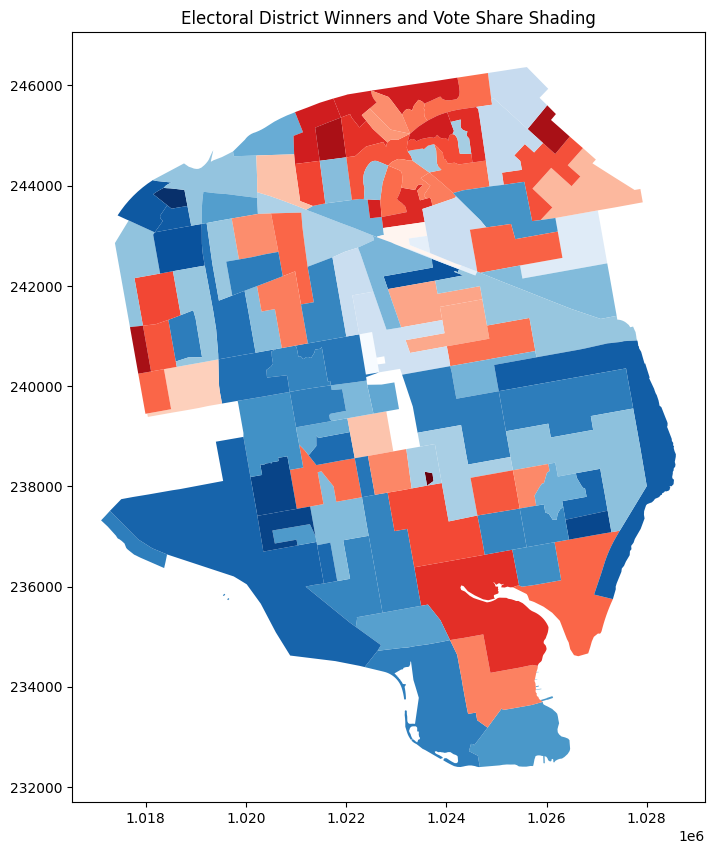

In [12]:
winners = gpd.GeoDataFrame(winners,geometry=winners['geometry'].apply(wkt.loads))

fig, ax = plt.subplots(1, figsize=(10, 10))
winners.plot(color=winners['color'], ax=ax)
ax.set_title("Electoral District Winners and Vote Share Shading")
plt.show()

In [29]:
demo_occ = af_full[['vote_share','ed_name','range_of_arrests','range_of_noise','cvap21bapp','mhhi21','venez21p',
                 'prican21p','colomb21p','domin21p','mean_arrests','mean_noise',
                 'rv21irp','rv21italp','pg20jrbp','pg20djtp','dpp20bs','adams213p','garcia213p','winda21p']].merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')

In [33]:
cor_cols = ['vote_share','mean_arrests','mean_noise','range_of_arrests','range_of_noise','cvap21bapp','mhhi21','venez21p',
                 'prican21p','colomb21p','domin21p','djt24p', 'wfp24p',
                 'rv21irp','rv21italp','pg20jrbp','pg20djtp','dpp20bs','adams213p','garcia213p','winda21p'] + wp_cols
corr_matrix = demo_occ[cor_cols].corr()
corr_matrix.sort_values('vote_share', ascending=False)

,vote_share,mean_arrests,mean_noise,range_of_arrests,range_of_noise,cvap21bapp,mhhi21,venez21p,prican21p,colomb21p,...,w2bgp,w2pservep,w2salep,w2oadp,w2farmp,w2conp,w2emrp,w2prodp,w2tranp,w2matp
vote_share,1.000000,-0.219430,-0.060049,-0.287564,0.032717,0.209220,-0.006337,0.168633,-0.074573,0.141761,...,-0.119837,-0.067076,-0.172309,0.009361,0.094571,0.114708,0.222656,-0.056842,0.071264,0.033236
w2cmp,0.287293,-0.125210,0.002365,-0.130108,0.132999,0.696231,-0.029777,0.469144,-0.284558,0.527358,...,-0.270932,0.045731,-0.267417,0.053041,0.120856,-0.055370,0.099986,-0.163454,0.175459,-0.108813
w2emrp,0.222656,0.012086,0.148702,-0.069513,0.178328,-0.061724,0.207430,0.133441,-0.059980,-0.027126,...,0.087865,-0.139338,-0.064822,-0.009595,-0.014315,0.415051,1.000000,0.195242,0.082669,-0.010035
w2scip,0.213730,-0.116258,-0.154539,-0.217331,-0.042965,0.320213,0.016927,0.177887,-0.176426,0.166725,...,-0.009413,0.048620,-0.046079,0.186756,-0.103967,0.053196,0.053490,0.189057,0.104454,0.046272
cvap21bapp,0.209220,-0.033669,-0.025731,-0.022001,0.129109,1.000000,0.106877,0.284857,-0.227601,0.329598,...,-0.208527,0.095196,-0.363637,0.154037,-0.225051,-0.252888,-0.061724,-0.015558,0.163578,-0.141519
venez21p,0.168633,-0.135494,0.042359,-0.185333,0.089842,0.284857,0.056403,1.000000,-0.074399,-0.174138,...,0.035212,-0.164039,-0.070240,-0.080304,-0.083021,0.082704,0.133441,0.058153,-0.050719,-0.015624
colomb21p,0.141761,-0.101941,-0.018372,-0.192908,0.080124,0.329598,0.022831,-0.174138,-0.300579,1.000000,...,-0.115130,0.484183,-0.106489,0.352240,0.133260,-0.126306,-0.027126,-0.245732,0.250558,-0.148041
w2admp,0.141056,-0.186658,0.214925,-0.350119,0.309427,0.271209,-0.126562,0.074386,-0.414287,0.501931,...,0.006217,0.508581,-0.216855,0.053917,-0.051912,0.015802,-0.135027,-0.205142,0.334781,0.045222
garcia213p,0.139027,-0.196710,-0.015716,-0.243240,0.006120,-0.004269,0.475388,0.040783,0.048105,-0.063973,...,0.114030,0.017649,0.141623,0.091644,0.070461,0.092065,0.395889,0.103724,0.117091,-0.033621
wfp24p,0.124569,-0.122080,0.022631,-0.269679,0.116817,0.360948,0.005019,0.302509,-0.212107,0.205029,...,-0.137024,0.039757,-0.058454,-0.068929,0.064017,0.110785,0.165906,-0.001614,0.155468,-0.189667


In [32]:
demo_occ['log_mhhi21'] = np.log(demo_occ['mhhi21'])

In [37]:
target = demo_occ['vote_share']
mod1 = sm.OLS(target, sm.add_constant(demo_occ[['cvap21bapp']])).fit()
mod2 = sm.OLS(target, sm.add_constant(demo_occ[['cvap21bapp','mean_arrests']])).fit()
mod3 = sm.OLS(target, sm.add_constant(demo_occ[['cvap21bapp','mean_arrests','domin21p','w2cmp','w2emrp','w2scip','w2salep']])).fit()

In [38]:
summary_col([mod1,mod2,mod3], stars=True)

,vote_share I,vote_share II,vote_share III
const,22.5277***,24.4007***,28.1371***
,(2.0483),(2.1612),(4.5110)
cvap21bapp,0.2244**,0.2167**,-0.0638
,(0.0991),(0.0972),(0.1553)
mean_arrests,,-0.5527**,-0.4463*
,,(0.2356),(0.2353)
domin21p,,,-0.0746
,,,(0.1056)
w2cmp,,,1.0134
,,,(0.6116)


In [40]:
#PCA on cor_cols
pca = PCA(n_components=2)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(demo_occ[cor_cols])
pca.fit(df_scaled)
pca_df = pd.DataFrame(pca.transform(df_scaled), columns=['PC1','PC2'])

In [41]:
pca_df['vote_share'] = demo_occ['vote_share']
pca_df['ed_name'] = demo_occ['ed_name']

In [43]:
# pca loadings
pca_loadings = pd.DataFrame(pca.components_, columns=cor_cols, index=['PC1','PC2']).T

In [44]:
pca_loadings

,PC1,PC2
vote_share,0.014184,-0.146830
mean_arrests,0.057002,0.201304
mean_noise,-0.017590,-0.165969
range_of_arrests,0.102650,0.288559
range_of_noise,0.006597,-0.228477
cvap21bapp,0.206662,-0.178322
mhhi21,-0.118825,-0.070446
venez21p,0.022797,-0.132838
prican21p,-0.054959,0.226368
colomb21p,0.117656,-0.230163
